In [ ]:
To Be Done

In [ ]:
# load libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import pandas_datareader.data as web
# define functions  
def get_wrds(conn,tickers=None):
  
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    
    query = f"""
        SELECT permno, date, ret, retx, prc       
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date,permno
    """
    returns = conn.raw_sql(query, date_cols=['date'])
    returns = returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
# Pivot data to have dates as index and tickers as columns
    returns = returns.pivot(index='date', columns='ticker', values='ret')    
    returns=returns[tickers]

    return returns



def get_factors(ff6=False):
    
    fama_french = web.DataReader("F-F_Research_Data_5_Factors_2x3_daily", "famafrench",start="1926-01-01")
    daily_data = fama_french[0]  # The first DataFrame contains the daily data
    daily_data.index = pd.to_datetime(daily_data.index)  # Ensure index is datetime
    if ff6==False:
        df_factor = daily_data[['RF','Mkt-RF']]  # Extract the Risk-Free Rate (RF)
    else:
        df_factor = daily_data[['RF','Mkt-RF','SMB','HML','RMW','CMA']]
        fama_french = web.DataReader("F-F_Momentum_Factor_daily", "famafrench",start="1926-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
    
    return df_factor/100

# Risk Management 

stale text

Fund managers, endowment managers, and professional delegated money managers in general very rarely can allocate capital freely

It is frequently the case that the ultimate investors impose on them a variety of restriction in the investment opportunity set.

- Restrictions on the sectors they invest
- Restrictions on the whether they can go short
- Restrictions on the use of explicit leverage
- Restrict on the use of derivative and embedded leverage

These type of restrictions are simple in the sense that they simply limit the set of instruments you are considering. 

They are static in nature.

Another set of constraints imposes time-varying restrictions on what the manager can do

- Risk limits: given a model for risk, it specifies that the portfolio must have variance lower than a certain limit
- Tracking error constraints: given a benchmark, this imposes limits on the portfolio residual risk--the volatility of the portfolio abnormal return relative to the benchmark


What makes implementation of these limits challenging is that risk is highly time-varying.



**🎯 Learning Objectives**

In this section we will learn how did deeper into risk management
By the end of this chapter, you should be able to:


1. **Think about risk as a delegate**
2. **Build portfolio risk from the ground up**
1. **Decompose factor risk and evaluate best hedging opportunities**
2. **Think about risk dynamically**
   







## Risk Taking If You’re the **Delegate**



Now imagine you’re a **fund manager** investing on behalf of others.

You may be evaluated based on:
- **Performance relative to a benchmark**
- **Short-term volatility**
- **Client satisfaction or redemptions**

In this case, your **utility function is no longer your own**. You may also face:
- **Constraints** (e.g., can't hold too much cash)
- **Reputation risks** (doing poorly relative to peers)
- **Incentives** tied to short-term returns

*  The delegate certainly has **stop loss rule**--at some point the principal will pull the plug
*  If the manager lose more than that amount they are forced to liquidate their positions and they are likely to be fired
*  Such stop loss is particularly biding for new managers
*  This stop loss might be explicit: the fund principal literally tells what it is
*  But most likely is implicitly--there is a loss that investors will freak out and pull out
*  You got to think for yourself and have very clearly what the number is
*  Investing as a delegate without that number in mind is reckless
---

### 🔁 Summary: Why This Distinction Matters

| Perspective | Risk Tolerance | Goal | Constraints |
|-------------|----------------|------|-------------|
| Principal   | Personal        | Maximize lifetime utility | Few (internal) |
| Delegate    | Institutional   | Maximize performance within mandate | Many (external)  |

Understanding whether you’re the principal or delegate affects:
- Portfolio size,
- Reaction to volatility,
- Interpretation of performance metrics (like Sharpe ratios).

---

### ✅ Check Your Understanding

**Q1**: Why might a delegate choose a lower-risk portfolio than a principal?

<details>
<summary>Click to see the answer</summary>
Because delegates often face external constraints and career risks. Their incentives may penalize short-term underperformance, leading them to reduce exposure to volatility—even if it means lower expected returns.
</details>

---

👉 In the next section, we’ll use this framework to build actual portfolios that mix risky and risk-free assets.






### From Maximum Losses to Portfolio Risk  

This might have to move to capital allocation II




* Lets think in terms of the one-year ahead looses you are comfortable with. 
* This can come from your internal judgment or from a stop loss reasoning
* Lets that you want to loose more than L (L is a number like 20%) with probability lower than p (say 5%)

$$Prob(rf+xr_p\leq -L)=p$$


* assume $rf=\mu\approx 0$--for example if the horizon is short


first step is to transform our variable in into a standard normal random variable

$$Prob(\frac{xrp}{x\sigma(rp)}\leq -\frac{L}{x\sigma(rp)})=p$$

We have that $\frac{xrp}{x\sigma(rp)}\sim N(0,1)$, then 


$$F(-\frac{L}{x\sigma(rp)})=p$$

* Where  F is the CDF of a standard normal, and $F^{-1}$ is it's quantile function
* F takes a number in the real line and returns a probability
* $F^{-1}$ take a probability and returns a number in the real line

$$F^{-1}(p)x\sigma\geq-L$$

Then 
 

$$x\sigma\leq-\frac{L}{F^{-1}(p)}$$


Lets do a calculation

for $p=5 \%$, $L=30\%$ what do we get?

Note that you will need the normal quantile function


In [ ]:
from scipy.stats import norm
norm.ppf(0.05)

-1.6448536269514729

You might want to incorporate your views on the portfolio expected return
- That is relevant in case your horizon is one year or longer. 
- For horizons that are 1 month or shorter you are safe ignoring the expected value since the volatility totally dominates it

You might adjust for deviations from normality by augmenting your losses by a factor $h\geq1$


The more you invest, the higher the expected growth $x\mu+rf$, but also the higher your wealth volatility $x\sigma$


$$x(hF^{-1}(p)\sigma+\mu)+rf\geq-\overline{L}$$



$$x\sigma(hF^{-1}(p)+\frac{\mu}{\sigma})+rf\geq-\overline{L}$$

Now note that $F^{-1}(p)$ is a negative number and $\frac{\mu}{\sigma}$ is positive


Lets first assume $hF^{-1}(p)+\frac{\mu}{\sigma}<0$ which is the realistic case, unless you are [James Simmons](https://en.wikipedia.org/wiki/Jim_Simons)


$$x\sigma\leq-\frac{\overline{L}+rf}{(hF^{-1}(p)+\frac{\mu}{\sigma})}$$

- A higher risk-free rate means you can take more vol (holding L fixed), since you start from a higher expected baseline
  - It is natural to have a real rate here since you probably care about your purchasing power
- The higher the Sharpe ratio, the less negative is $hF^{-1}(p)+\frac{\mu}{\sigma}$ and the higher the volatility you choose to take
- The higher your SR, the less likely you hit that loss!

Lets plug some numbers with $rf=1\%$ and SR=0.4 ( that is the market Sharpe ratio)

$$-\frac{0.3+0.01}{2*(-1.64)+0.4}$$

In [ ]:
from ipywidgets import interact
from IPython.display import display

def calculate_sigma(L, h, p, sr, rf):
	return -(L + rf) / (h * norm.ppf(p) + sr)

@interact(StopLoss=(0.05, 0.5, 0.05), p=(0.01, 0.1, 0.01), h=(1, 4, 0.5), SharpeRatio=(0.1, 3, 0.1))

def calculate_optimal_vol(StopLoss, p, h, SharpeRatio, rf=0.02):
	sigma = calculate_sigma(StopLoss, h, p, SharpeRatio, rf)
	return f"Optimal vol: {sigma:.2%}"
	

interactive(children=(FloatSlider(value=0.25, description='StopLoss', max=0.5, min=0.05, step=0.05), FloatSlid…

- What happens if you take a 10% loss?
- What happens if you have a very high SR?
- What happens if you suddenly think returns are very fat tailed?
- 



### Risk-Budget Constraint

- How this is used in practice?
- In practice a fund or a "trading pod" is allocated some capital and some maximum risk-limits
- If you breach the risk-limit you have to de-risk
- Why is typically so hard to de-risk?
- Think about Melvin Capital (fund that failed during the Gamestop craziness)
  - How should you think about de-risking? Should you comply? What is the trade-off?
  - What are the incentives the manager faces? What does it depend on?
  - How are these incentives different from a wealth individual invest in her own behalf?
- Should our past losses matter for our decision to de-risk?

## Managing Factor Risk



The betas measure the exposure of the asset return to the factor, but it does not give an accurate way of thinking which factor drives the most of the variation in the asset as factors can have very different variances

$$1=\frac{Cov(r^i_t,r^i_t)}{Var(r^i_t)}=\frac{Cov(r^i_t,\sum_j^m \beta_{i,j}f^j_t+\epsilon^i_t)}{Var(r^i_t)}$$

$$1=\frac{\sum_j^m \beta_{i,j}Cov(r^i_t,f^j_t)+\sigma^2_{\epsilon}}{Var(r^i_t)}$$


The the variance share of factor j is $\frac{\beta_{i,j}Cov(r^i_t,f^j_t)}{Var(r^i_t)}$ and the share of non-factor variance is $\frac{\sigma^2_{\epsilon}}{Var(r^i_t)}$



In [ ]:
VarianceDecomposition=pd.DataFrame([],index=tickers,columns=X.columns[1:])
FactorLoadings=pd.DataFrame([],index=tickers,columns=X.columns[1:])
VarianceIdiosyncratic=pd.DataFrame([],index=tickers,columns=['epsilon'])
for ticker in tickers:
    y = df_ETF[ticker]
    Factors = df_factor.drop(columns=['RF'])
    X = sm.add_constant(Factors) 
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    # get the covariance matrix of the factors and the dependent variable
    CovMatrix=pd.concat([y,X.iloc[:,1:]],axis=1).cov()
    # get the column of the covariance matrix corresponding to the dependent variable and exclude itself to get the covariance of 
    # the dependent variable with each factor
    FactorLoadings.loc[ticker,:]=model.params[1:]
    VarianceIdiosyncratic.loc[ticker,'epsilon']=model.resid.var()
    VarianceDecomposition.loc[ticker,:]=model.params[1:]*CovMatrix.iloc[1:,0]/y.var()*100
    # Get the residual variance
    VarianceDecomposition.at[ticker,'epsilon']=model.resid.var()/y.var()*100



np.floor(VarianceDecomposition)

,Mkt-RF,SMB,HML,RMW,CMA,MOM,epsilon
MTUM,85,-1,0,1,0,4,8.0
SPMO,85,-1,0,0,-1,2,13.0
XMMO,83,4,0,-1,0,-2,13.0
IMTM,68,-1,-1,1,-1,-1,31.0
XSMO,70,16,1,-1,0,-3,14.0
PDP,90,1,-1,0,1,-2,7.0
JMOM,90,0,1,0,0,-1,6.0
DWAS,64,23,-1,2,0,1,8.0
VFMO,82,7,-2,2,0,2,4.0
XSVM,60,18,10,-2,0,1,10.0


What do we learn?

Decompositions like that extensively in the money management industry

- Used to classify managers in terms of styles--often called style analysis
- Used to control own portfolio factor risk to satisfy investment mandates 

When looking at a portfolio/fund you have two approaches to measure it's factor exposures
- Top down: what we did so far. run a time-series regression of the portfolio returns on the factor return
- Bottom up: from the asset factor exposures build the portfolio factor exposure


What are the benefits and drawbacks of each?


## Variance-Covariance Matrix Estimation

A key step in measuring risk well is to have a good estimate of the covariance-matrix

The covariance matrixes can be thought as two pieces

- The overall variance of each asset
- The degree of co-movement between them, i.e. the correlation

The variance piece tends to be easier--for each asset you need to estimate one moment

The correlation is harder because as the assets grow, the number of correlation grows explosively

Here three different approaches to estimate a portfolio risk

Notation: 

- a vector of asset excess returns R (N by 1),
- weights W (N by 1),

You can estimate your portfolio variance in three different ways

- Var(W'R): compute the portfolio in sample return variance
- W'Var(R)W: Compute the individual assets variance-covariance matrix
- Var(W' @(A+Bf+U)): Use a factor model

- Note that in the first method we skip the estimation of the covariance-matrix and estimated the variance of the portfolio directly
    - For example, that is the approach that we we take to estimate the market portfolio variance
    - You are assuming that 
- What are the advantages and disadvantages of each approach?
- Which approach is unlikely to work well for funds that trade a lot?
- Which approach needs more data?
  




$Var(R)$ can be very large

- For N assets, this means estimating $(N^2-N)/2$ correlations and N variances
- With limited time-series data our estimator will mistake chance for real relationships

We need need to impose something in the data.

1. Use factor models: 
   - Essentially assume that all co-movement is captured by the factors
   - any residual co-movement is noise and we assume it is zero (even if the data says it is not)
2. Shrink the covariance matrix:
   - We shrink all correlations to zero
   - shrink all variances to the average



### Factor-Based Covariance Estimation

Notation

$$R_t=B@F_t+u_t$$

where 

- B is N by M
- F is M by 1
- u is N by 1

Then the variance-covariance matrix is

$$Var(R_t)=B@Var(F_t)@B.T+Var(U_t)$$



array([1.1707586174771113e-05, 2.080317521040718e-05,
       2.751170238189328e-05, 3.94335833263887e-05,
       3.1943920861237906e-05, 1.5759114393840486e-05,
       1.2449711502349668e-05, 2.1222405771159763e-05,
       1.0922197920452e-05, 2.7637503923225132e-05, 6.784116852203246e-05],
      dtype=object)

In [ ]:
Var_F=Factors.cov()
Cov=FactorLoadings @ Var_F @ FactorLoadings.T + np.diag(VarianceIdiosyncratic.values.reshape(-1))
Cov

,MTUM,SPMO,XMMO,IMTM,XSMO,PDP,JMOM,DWAS,VFMO,XSVM,QMOM
MTUM,0.00016,0.000143,0.000155,0.000117,0.000152,0.000158,0.000141,0.000175,0.000159,0.000139,0.000169
SPMO,0.000143,0.000159,0.00015,0.000114,0.000146,0.000152,0.000137,0.000166,0.000152,0.000138,0.00016
XMMO,0.000155,0.00015,0.0002,0.000127,0.000178,0.000171,0.000153,0.000203,0.000175,0.000173,0.000184
IMTM,0.000117,0.000114,0.000127,0.000136,0.000128,0.000127,0.000115,0.000144,0.000129,0.000127,0.000133
XSMO,0.000152,0.000146,0.000178,0.000128,0.000227,0.000173,0.000154,0.000223,0.000184,0.000198,0.000192
PDP,0.000158,0.000152,0.000171,0.000127,0.000173,0.000187,0.000154,0.000198,0.000174,0.000163,0.000184
JMOM,0.000141,0.000137,0.000153,0.000115,0.000154,0.000154,0.000152,0.000173,0.000154,0.000148,0.00016
DWAS,0.000175,0.000166,0.000203,0.000144,0.000223,0.000198,0.000173,0.000284,0.000215,0.000218,0.000229
VFMO,0.000159,0.000152,0.000175,0.000129,0.000184,0.000174,0.000154,0.000215,0.000195,0.000177,0.000196
XSVM,0.000139,0.000138,0.000173,0.000127,0.000198,0.000163,0.000148,0.000218,0.000177,0.000252,0.000175


### Shrinkage methods

Say our covariance in the data is $Var(R)$

We will then construct our estimator as

$$\hat{Var}=(1-\tau)Var(R)+\tau I\sigma^2_avg$$

- the $\tau$ parameter is the amount of shrinkage
- the worse the data is the more you apply
- In the limit al correlations are zero and all variances are the same
- Sometimes people mix and match--using a factor model and then shrink the residuals covariance matrix
- Particularly sensible approach when we know differences in factor exposures are important

In [ ]:
tau=0.5
var_avg=df_ret.var().mean()

N=df_ret.shape[1]
Var_shrink=df_ret.cov()*(1-tau)+tau*np.eye(N)

> Conceptual check 



Suppose you are trying to construct the minimum variance portfolio--say you think expected returns are undistinguishable across the funds, so you simply want to minimize variance

your optimal weight, if you knew the covariance matrix is

$$1'Var(R^e)^{-1}$$

- If we compare the in-sample Variance of our minimum variance portfolios for
    - The unrestricted case
    - The single-factor covariance
    - The multi-factor covariance
    - The shrinkage case

- which one will have lowest variance? What will have the highest? 
- Now split the sample in two. Repeat the covariance estimation procedure for each of these approaches for the first half of the sample
- Now use the weights to compute the variance of each of the portfolios in the second half
- Is the order likely to change? 





###  How will your portfolio risk change as you add positions


You have portfolio $X_0$ and you want to sell w of your positions to invest in a fund with portfolio $X_1$. How your portfolio variance will change as a function of you reallocation?

- The answer is simple

$$Var(wX_1R_t+(1-w)X_0R_t)-Var(X_0R_t)$$

- But also kind of misleading since you might not have good data to estimate the variance of the new portfolio

- Now if you know each portfolio factor betas,$\beta_0=X_0@B$ and $\beta_1=X_1@B$ , and at least one of this portfolio is large and well diversified, then for small tilts, i.e. $w$ small, we have 


$$\frac{Var(wX_1R_t+(1-w)X_0R_t)-Var(X_0R_t)}{\Delta w}|_{w\approx 0} =\beta_1Var(F)\beta_0'$$


- The fact that one is well diversified just means that you can ignore the covariance-terms of the portfolios asset specific risks

- So you see above why a large pool of money when allocating money to an active manager will want to regulate their factor exposure

- funds with similar volatilities will be perceived as very different risks depending on how the exposure of portfolio relates to the exposure of the fund

For example, look at how your portfolio risk change if you go from an equal weighted portfolio of these ETFS to just investing in one of them, say MTUM




Here I will use i,j for a individual stock


$$r^{e,i}=\alpha_i+\beta_{i,f}f+u_{i}$$

- non-factor component $u_i$ of the asset return of asset $i$. Assumed to uncorrelated between any two assets

Now this is just a regression!

We have that

$$Var(r^{e,i})=\beta_i^2Var(f)+var(u_{i})$$


Now to harvest the power of the factor model for risk management we need to make a big assumption

 $$cov(u_{i,t},u_{j,t})=0$$

The assumption here is that our factors--in this case a single factor--captures all the co-movement across stocks

This is very strong assumption if you just have a single factor

But gets closer to the truth as you saturate the model with factors (funds use 10-100 factors!)


This assumption is essential to make progress otherwise we are just moving the estimation problem 

With this assumption pairwise covariances are fully captured by the factor exposures

$$Cov(r_t^{e,i},r_t^{e,j})=Cov(\alpha_i+\beta_{i}f_t+u_{i,t},\alpha_j+\beta_{j}f_t+u_{j,t})=\beta_i\beta_jVar(f_t)$$

And the covariance matrix is simply


$$
\left[\begin{array}{cc}
\beta_i^2 & \beta_i\beta_j \\
\beta_i\beta_j &  \beta_j^2 
\end{array}\right]var(f_t)+\left[\begin{array}{cc}
var(\epsilon_{i,t}) & 0 \\
0&  var(\epsilon_{j,t})
\end{array}\right]$$

We see that now for N assets we only need to estimate N factor exposures, N asset specific volatilities , and the factor volatility


If we were estimating a variance-covariance matrix without imposing the factor model we would have to estimate N covariances and $(N^2-N)/2$ covariance terms: $2N+1$ vs $(N^2-N)/2+N$ is huge as N grows



>**Practice**
> - Choose a a few tickers  tickers you like plus SPY
> - Estimate their unrestricted covariance matrix
> - Estimate the single-factor model (single factor=SPY) 
> - Build the factor implied covariance matrix
> - Can you compare the number of parameters you need to estimate in each case
> - Can you discuss if it such model is a good one in this case
> - Can you calculate the implied portfolio variance for a set of weights of your choosing?



<AxesSubplot:xlabel='Date'>

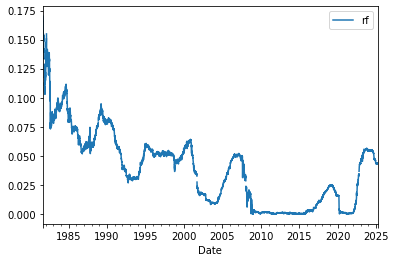

In [ ]:
from pandas_datareader.data import DataReader
import datetime


# first we connect with WRDS database using the wrds package so we need to install it first and import it
%pip install wrds
import wrds
# lets connect with  the wrds database
conn = wrds.Connection()

# get our stock returns
Tickers=['WMT','JPM','AAPL','MSFT','GOOGL','AMZN','META','TSLA','NVDA','BRK.B']
df=get_daily_wrds(conn,tickers=Tickers)

# GET RISK FREE RATE
start_date = datetime.datetime(1960, 1, 1)  # Start date (adjust as needed)
end_date = datetime.datetime.now()          # End date
df_rf = DataReader("DGS3MO", "fred", start_date, end_date)
df_rf.reset_index(inplace=True)
df_rf.columns = ["Date", "rf"]
df_rf.rf=df_rf.rf/100
df_rf.set_index("Date", inplace=True)

# merge with the risk-free rate
df=df.merge(df_rf/252, left_index=True, right_index=True,how='left')
#
df_re=df.drop(columns='rf').sub(df['rf'],axis=0)
df_re.tail()

In [ ]:
df_ff6=get_factors('ff6',freq='daily').dropna().drop(columns=['RF'])
df_ff6.tail()

# Define the factors and the market factor

factor = 'Mkt-RF'
df_factor=df_ff6[factor]
df_merged = df_re.merge(df_factor, left_index=True, right_index=True, how='inner')
df_merged.tail()


In [ ]:
import statsmodels.api as sm


# Initialize lists to store the results

Beta = []
residuals = []
Alpha_se = []
# Run univariate regressions
# here we are running a regression of each factor on the market factor
for stock in Tickers:
    X = sm.add_constant(df_merged[factor])
    y = df_merged[stock]
    model = sm.OLS(y, X).fit()
    Beta.append(model.params[factor])
    # I am storying the entire time-series of residuals
    residuals.append(model.resid)


Beta = np.array(Beta)

VarF=df_merged[factor].var()
# Calculate the variance-covariance matrix of the residuals
residuals_matrix = np.vstack(residuals)
VarU = np.cov(residuals_matrix)
#now under the assumption that the residuals are uncorrelated ( they are not!)


VarU_uncorr = np.diag(np.diag(np.cov(residuals_matrix.T)))


print("Beta:", Beta)
print("VarU:")
display(VarU*12)
print("VarU_uncorr:")
display(VarU_uncorr*12)

Alpha: [0.00324195 0.04349594 0.03955175 0.04143328 0.08341451]
Beta: [ 0.19954208 -0.13719646 -0.09352601 -0.16246303 -0.16205943]
Sigma_e:


array([[ 1.00563313e-02, -9.24337485e-04, -2.82466739e-03,
        -5.14453377e-04,  1.36587317e-06],
       [-9.24337485e-04,  1.01484903e-02,  3.74978561e-04,
         4.47136746e-03, -3.41595108e-03],
       [-2.82466739e-03,  3.74978561e-04,  5.70013428e-03,
        -3.92044656e-04,  5.51842057e-04],
       [-5.14453377e-04,  4.47136746e-03, -3.92044656e-04,
         4.46193077e-03, -7.83303223e-04],
       [ 1.36587317e-06, -3.41595108e-03,  5.51842057e-04,
        -7.83303223e-04,  2.03162979e-02]])

Sigma_e_uncorr:


array([[0.00083899, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00270649, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00027303, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01326286, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00629202,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00475249]])

## Dynamic Risk Management




The variance of a portfolio is

$$Var_t(X_tR^e_{t+1})$$

where 
- $X_t$ is your portfolio weights in date t for investment in date t+1,
- $R_{t+1}$ is the vector of asset excess returns during the holding period, i.e. from date $t$ to date $t+1$.
- $Var_t()$ denotes the variance of this random variable given all we know in date $t$




The idea here is

- Correlations do change, but they change slower than variance so we will use standard rolling window to estimate correlations--essentially assuming that they are constant in our forecast horizon.

- And use our model to forecast the the variance

IF returns have a factor structure we have

$$Var_t(R_{t+1})=Var(\beta_t F_{t+1}+u_{t+1})=\beta_t Var_t(F) \beta_t'+Var_t(u)$$


We thus need to produce time-varying estimates 

- For betas
- For factor covariance matrix
- For each asset specific idiosyncratic volatility


> There is no right way of estimating these things
> Whatever works best out of sample

- We already discussed good approaches to estimate betas and variances (Chapter 8)
- Here we simply put these estimates together

- One new trick to estimate factor covariances is to build it from correlations and variance estimates
  - This is useful because correlations tend to move slower than variances
  - (One can use this trick to estimate betas as well) 

- We often will rely on the fact that we believe we can measure high frequency variation in market volatility better than in the other factors
- Together with the fact that vols tend to move together it is natural to make assumptions like

$$\Sigma_{u,t}=\Sigma_{u}*\frac{\sigma^2_{market,t}}{\sigma^2_{market}}$$



$$\Sigma_{F,t}=diag(\Sigma_{F,t})^{1/2}Corr~diag(\Sigma_{F})^{1/2}$$

- where Corr is the correlation coming from a 2-5 year moving sample  
- diag(\Sigma_{F})^{1/2} is a diagonal matrix with factor volatilities estimated at much higher frequencies
  - Realized variance for the factor (using daily and even intra-day data)
  - Garch/ARCH models 
  - Option implied volatility (specially for the market, but VIX can be useful more broadly)



Below we will do an example where we build a covariance matrix using this "mixed frequency" approach

## Tracking Error Mandates


Active managers operating in a  mutual often have limits on how much they can deviate from their benchmark

This happens at the same time that they have incentives to beat it , i.e. their value added is $E[R-R^b]$

> What is the difference between this notion of value added and alpha?

The tracking error is simply the volatility of a relative return


$$\sqrt{Var(R-R^b)}$$


In the ideal scenario  you have a constant edge relative to the benchmark--no no tracking error--but still value added

Of course that is virtually impossible, so you accept some tracking error to get some extra

- You are effectively short the benchmark
- To zero your vol you simply hold the benchmark portfolio
  

Benchmarks are typically tradable. A very common one is the S&P500

Your tracking error has two parts

$$Var(R-R^b)=Var(\alpha+\beta R^b+u-R^b)=(\beta-1)^2Var(R^b)+var(u)$$

The first piece is your exposure to the benchmark. 

- How can you get this piece to zero? Is it costly?

The second piece is everything else

- how can you get to zero? is it costly?

Your value added also has two pieces

$$E[R-R^b]=\alpha+(\beta-1)E[R^b]$$

- If benchmark has positive premium you can "beat it" simply by investing in higher beta stocks! (or leveraging up)
- For example if you have no original ideas and have a track record allowance of 5% how much value added you can produce?
    - What your answer depends on?
  
- Suppose you also have good trading ideas, i.e. alpha, how do you trade-off beta and alpha if your goal is to maximize value added?


- How is this related to the "betting against beta" phenomena?



 

